<a href="https://colab.research.google.com/github/yashasvi2601/NLP/blob/main/NLP_Group_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install taxii2-client stix2 spacy pandas
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.8/177.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.9/65.9 kB 2.9 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=390e1660becb238fc81d57b72d240cd0ce46cae183faa0b39f7efd72ebe6abd9
  Stored in directory: /root/.cache/pip/wheels/1a/97/32/461f837398029ad76911109f07047fde1d7b661a147c7c56d1
Successfully built antlr4-python3-runtime
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 62.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel'

In [4]:
import requests

url = "https://cti-taxii.mitre.org/taxii/"
try:
    response = requests.get(url, timeout=10)
    print(f"Server Response: {response.status_code}")
except requests.exceptions.RequestException as e:
    print(f"Error connecting to MITRE ATT&CK TAXII Server: {e}")


Error connecting to MITRE ATT&CK TAXII Server: HTTPSConnectionPool(host='cti-taxii.mitre.org', port=443): Max retries exceeded with url: /taxii/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x7a694a5a8510>, 'Connection to cti-taxii.mitre.org timed out. (connect timeout=10)'))


In [5]:
import json
import spacy
import pandas as pd

# Load spaCy NLP model
nlp = spacy.load("en_core_web_sm")

# Load MITRE ATT&CK JSON file (Uploaded in Colab)
file_path = "/content/enterprise-attack.json"  # Update path if needed
with open(file_path, "r", encoding="utf-8") as f:
    attack_data = json.load(f)

# Extract TTPs
def extract_ttps(data):
    techniques = []
    for obj in data["objects"]:
        if obj.get("type") == "attack-pattern":  # Filter for techniques
            techniques.append({
                "ID": obj.get("external_references", [{}])[0].get("external_id", "N/A"),
                "Name": obj.get("name", "N/A"),
                "Description": obj.get("description", "No description available"),
                "Tactic": ", ".join([phase.get("phase_name", "N/A") for phase in obj.get("kill_chain_phases", [])])
            })
    return pd.DataFrame(techniques)

# Preprocess descriptions
def preprocess_text(df):
    def clean_text(text):
        doc = nlp(text)
        return " ".join([token.lemma_ for token in doc if not token.is_stop and token.is_alpha])

    df["Processed_Description"] = df["Description"].apply(clean_text)
    return df

# Run processing
ttp_df = extract_ttps(attack_data)
ttp_df = preprocess_text(ttp_df)
ttp_df.to_csv("mitre_ttps.csv", index=False)

print("Processing complete. Data saved to 'mitre_ttps.csv'.")


Processing complete. Data saved to 'mitre_ttps.csv'.


In [6]:
import spacy
import pandas as pd

# Load spaCy NLP model
nlp = spacy.load("en_core_web_sm")

# Load extracted MITRE TTPs
ttp_df = pd.read_csv("mitre_ttps.csv")

# Function to extract key entities and relationships
def extract_relationships(text):
    doc = nlp(text)

    entities = [token.text for token in doc if token.pos_ in ["NOUN", "PROPN"]]
    actions = [token.lemma_ for token in doc if token.pos_ == "VERB"]

    return {
        "Entities": ", ".join(entities),
        "Actions": ", ".join(actions)
    }

# Apply the function to each description
ttp_df[["Entities", "Actions"]] = ttp_df["Description"].apply(lambda x: pd.Series(extract_relationships(x)))

# Save processed data
ttp_df.to_csv("mitre_ttps_with_relations.csv", index=False)
print("✅ Dependency parsing complete! Data saved to 'mitre_ttps_with_relations.csv'.")


✅ Dependency parsing complete! Data saved to 'mitre_ttps_with_relations.csv'.


In [7]:
import json
import pandas as pd

# Load processed MITRE TTP data
ttp_df = pd.read_csv("mitre_ttps_with_relations.csv")

# Prepare nodes and links for D3.js graph
nodes = [{"id": row["Name"], "group": row["Tactic"]} for _, row in ttp_df.iterrows()]
links = [{"source": row["Name"], "target": entity, "value": 1} for _, row in ttp_df.iterrows() for entity in row["Entities"].split(", ") if entity]

# Save JSON output
graph_data = {"nodes": nodes, "links": links}
with open("ttp_graph.json", "w") as f:
    json.dump(graph_data, f, indent=4)

print("✅ JSON file 'ttp_graph.json' created for D3.js visualization.")


✅ JSON file 'ttp_graph.json' created for D3.js visualization.


In [8]:
html_code = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>TTP Network Graph</title>
    <script src="https://d3js.org/d3.v7.min.js"></script>
    <style>
        body { font-family: Arial, sans-serif; }
        .node { stroke: #fff; stroke-width: 1.5px; }
        .link { stroke: #999; stroke-opacity: 0.6; }
    </style>
</head>
<body>
    <h2>TTP Relationship Network</h2>
    <svg width="900" height="600"></svg>

    <script>
        // Load JSON data
        d3.json("ttp_graph.json").then(function(graph) {
            const width = 900, height = 600;

            const svg = d3.select("svg")
                          .attr("width", width)
                          .attr("height", height);

            const simulation = d3.forceSimulation(graph.nodes)
                .force("link", d3.forceLink(graph.links).id(d => d.id).distance(150))
                .force("charge", d3.forceManyBody().strength(-300))
                .force("center", d3.forceCenter(width / 2, height / 2));

            const link = svg.selectAll(".link")
                .data(graph.links)
                .enter().append("line")
                .attr("class", "link")
                .style("stroke-width", d => Math.sqrt(d.value));

            const node = svg.selectAll(".node")
                .data(graph.nodes)
                .enter().append("circle")
                .attr("class", "node")
                .attr("r", 10)
                .style("fill", d => d3.schemeCategory10[d.group.length % 10])
                .call(drag(simulation));

            node.append("title")
                .text(d => d.id);

            simulation.on("tick", () => {
                link.attr("x1", d => d.source.x)
                    .attr("y1", d => d.source.y)
                    .attr("x2", d => d.target.x)
                    .attr("y2", d => d.target.y);

                node.attr("cx", d => d.x)
                    .attr("cy", d => d.y);
            });

            function drag(simulation) {
                return d3.drag()
                    .on("start", (event, d) => {
                        if (!event.active) simulation.alphaTarget(0.3).restart();
                        d.fx = d.x;
                        d.fy = d.y;
                    })
                    .on("drag", (event, d) => {
                        d.fx = event.x;
                        d.fy = event.y;
                    })
                    .on("end", (event, d) => {
                        if (!event.active) simulation.alphaTarget(0);
                        d.fx = null;
                        d.fy = null;
                    });
            }
        });
    </script>
</body>
</html>
"""

# Save to index.html
with open("index.html", "w") as file:
    file.write(html_code)

print("✅ 'index.html' saved successfully!")


✅ 'index.html' saved successfully!


In [9]:
from IPython.display import IFrame

IFrame(src="./index.html", width="100%", height="600px")


<ipython-input-10-c7d9b02137a6>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ttp_names, y=counts, palette="viridis")


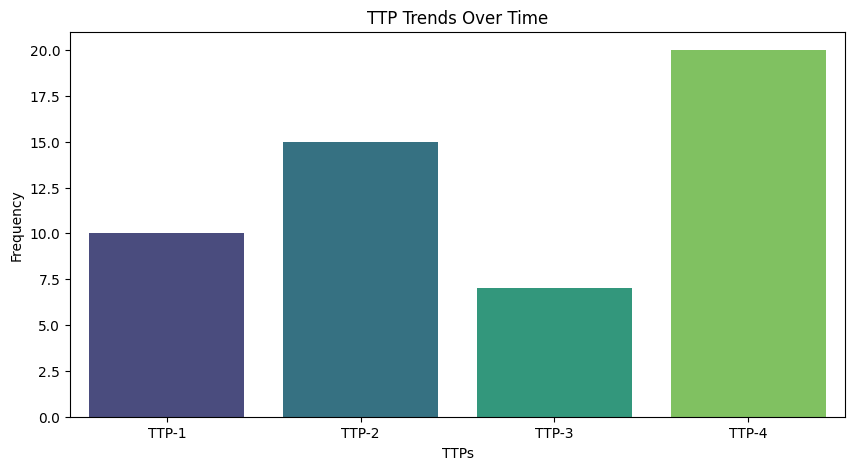

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example Data
ttp_counts = {"TTP-1": 10, "TTP-2": 15, "TTP-3": 7, "TTP-4": 20}
ttp_names = list(ttp_counts.keys())
counts = list(ttp_counts.values())

# Bar Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=ttp_names, y=counts, palette="viridis")
plt.xlabel("TTPs")
plt.ylabel("Frequency")
plt.title("TTP Trends Over Time")
plt.show()


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np

# Convert descriptions to feature vectors
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(ttp_df["Processed_Description"])

# Perform clustering
num_clusters = 5  # Adjust based on dataset
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
ttp_df["Cluster"] = kmeans.fit_predict(X)

# Show cluster assignments
print(ttp_df[["ID", "Name", "Cluster"]].head())


          ID                           Name  Cluster
0  T1055.011  Extra Window Memory Injection        0
1  T1053.005                 Scheduled Task        2
2  T1205.002                 Socket Filters        1
3      T1066   Indicator Removal from Tools        2
4  T1560.001            Archive via Utility        2


In [12]:
def match_real_world_ttps(real_world_logs, ttp_descriptions):
    matched_ttps = []
    for log in real_world_logs:
        for _, row in ttp_descriptions.iterrows():
            if row["Name"].lower() in log.lower():
                matched_ttps.append((log, row["ID"], row["Name"]))
    return matched_ttps

# Example real-world logs (replace with actual data)
real_world_logs = ["Phishing attack detected", "Privilege escalation attempt", "Malware executed via PowerShell"]

matches = match_real_world_ttps(real_world_logs, ttp_df)
for match in matches:
    print(f"Log: {match[0]} -> Matched TTP: {match[1]} ({match[2]})")


Log: Phishing attack detected -> Matched TTP: T1566 (Phishing)
Log: Phishing attack detected -> Matched TTP: T1053.002 (At)
Log: Privilege escalation attempt -> Matched TTP: T1053.002 (At)
Log: Malware executed via PowerShell -> Matched TTP: T1587.001 (Malware)
Log: Malware executed via PowerShell -> Matched TTP: T1588.001 (Malware)
Log: Malware executed via PowerShell -> Matched TTP: T1059.001 (PowerShell)
Log: Malware executed via PowerShell -> Matched TTP: T1086 (PowerShell)


In [21]:
!pip install dash pandas

import dash
from dash import dcc, html
import pandas as pd
import plotly.express as px

app = dash.Dash(__name__)

# Sample Data
data = {
    "TTP": ["T1071", "T1059", "T1105", "T1203"],
    "Description": ["Application Layer Protocol", "Command and Scripting Interpreter", "Ingress Tool Transfer", "Exploitation for Client Execution"],
    "Frequency": [50, 70, 40, 30]
}
df = pd.DataFrame(data)

# Layout
app.layout = html.Div(children=[
    html.H1(children="MITRE ATT&CK TTPs Dashboard"),
    dcc.Graph(figure=px.bar(df, x="TTP", y="Frequency", title="TTP Frequency"))
])

if __name__ == '__main__':
    app.run(debug=True, port=8050)


<IPython.core.display.Javascript object>